**Math 154 Kaggle Project: Marcel, Nick, Erik, and J.J.**



In this notebook, we'll walk through the first part of our Kaggle Group Project. We'll first give a description of the problem, then proceed to a discussion of data exploration, and a few of the algorithms that we tried. 

**The Problem**

Our task is to try to predict whether an individual will experience financial distress in the next two years, given several pieces of information about the individual, namely:

1.  Revolving Utilization of Unsecured Lines: The individual's total balance on credit cards and personal lines of credit divided by the sum of the individual's credit limits. 
2.  Age
3. Number of times the borrower has been 30-59 days past due (but no worse) in the past 2 years.
4. Debt Ratio: Monthly debt payments divided by monthly gross income.
5. Monthly Income
6. Number of Open Credit Lines and Loans
7. Number of times the borrower has been 90 days or more past due in the last two years.
8. Number of Real Estate Loans or Lines
9. Number of times the borrower has been 60-89 days past due (but no worse) in the past 2 years.
10. Number of dependents in the individual's family (excluding themselves)



Note the numbers of these features, for we'll refer to these features by number throughout the paper, for the sake of brevity.

This is a classification problem. We are given a training set of 150,000 obervations to develop our models, and a testing set of 100,000 observations by which the model will be judged, using the metric of area under the curve (AUC). 

**Data Exploration**

First, import some necessary packages.

In [56]:
import numpy as np 
import pandas as pd

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import io 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # for iterative imputation
from sklearn.model_selection import train_test_split # for splitting the training set into a train and test set.
from sklearn.metrics import roc_curve # for finding roc curves for learners
from sklearn.metrics import auc # for determining auc for learners
import matplotlib.pyplot as plt # for generating plots

Read in the train and test sets for the problem, and generate some descriptive statistics for the training set.





In [57]:
filename_train = "./GiveMeSomeCredit/cs-training.csv"
train = pd.read_csv(filename_train, index_col = 0) 

In [59]:
trainX = train.iloc[:, 1:11]
trainy = train.iloc[:,0]
filename_test = "./GiveMeSomeCredit/cs-test.csv"
testX = pd.read_csv(filename_test, index_col = 0) 

In [60]:
trainX.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


At first glance, there appear to be some pretty egregious values within the dataset, especially, when looking at the maximum values of features 1, 3, 4, 7, and 9, and in particular, the standard deviations for features 1 and 4 These variables in particular will merit further examination. We also see that there are several NA values within the dataset, too, for variables 5 and 9. 

In [61]:
trainX.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

We can also see that all the observations where NumberofDependents is NA also have NA values for MonthlyIncome.

In [62]:
trainX[(trainX["NumberOfDependents"].isnull() == True)].isna().sum()

RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           3924
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      3924
dtype: int64

We'll have to address both of these problems, outliers and missing values. Let's tackle the former one first, taking a look at values for age:

<AxesSubplot:>

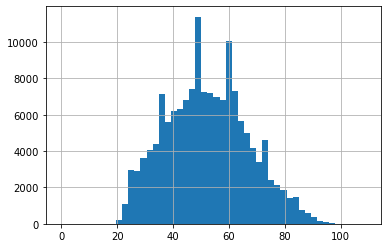

In [63]:
train["age"].hist(bins = 50)

Looks like a pretty healthy normal distribution. When we look at the density functions of age by value of the response variable we can also see that the distributions make sense, although it's interesting to note that borrowers who experienced distress seem to run younger than those who don't.

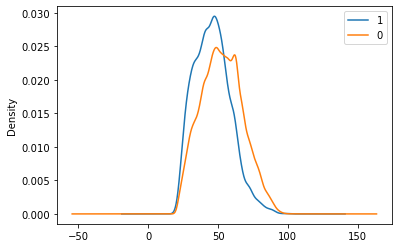

In [64]:
train[train["SeriousDlqin2yrs"] == 1]["age"].plot.density(label = '1')
train[train["SeriousDlqin2yrs"] == 0]["age"].plot.density(label = '0')
plt.legend()

Let's do a similar thing for variables 6, 8, and 10 of the dataset:

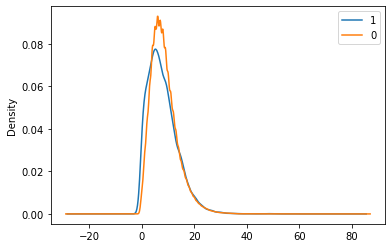

In [65]:
train[train["SeriousDlqin2yrs"] == 1]["NumberOfOpenCreditLinesAndLoans"].plot.density(label = '1') # density plots for variable 6
train[train["SeriousDlqin2yrs"] == 0]["NumberOfOpenCreditLinesAndLoans"].plot.density(label = '0')
plt.legend()

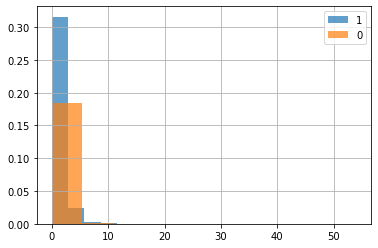

In [66]:
train[train["SeriousDlqin2yrs"] == 1]["NumberRealEstateLoansOrLines"].hist(density = 1, alpha=.70, label = '1') # density plots for variable 8
train[train["SeriousDlqin2yrs"] == 0]["NumberRealEstateLoansOrLines"].hist(density = 1, alpha=.70, label = '0') 
plt.legend()

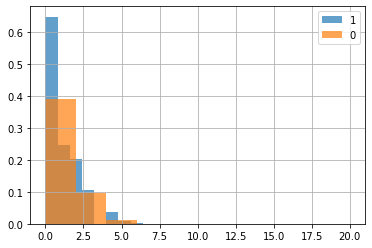

In [67]:
train[train["SeriousDlqin2yrs"] == 1]["NumberOfDependents"].hist(density = 1, alpha=.70, label = '1') # density plots for variable 8
train[train["SeriousDlqin2yrs"] == 0]["NumberOfDependents"].hist(density = 1, alpha=.70, label = '0')
plt.legend()

The plots for individuals with negative response variables seem to have higher densities at higher values than those for individuals with positive response variables, for variables 8 and 10. But overall, the takeaway is that there do not seem to be any irregularities in the distributions for these variables.

Now let's examine the distributions for variables 3, 7 and 9, which seem to be quite similar:

In [68]:
pd.DataFrame(train["NumberOfTime30-59DaysPastDueNotWorse"].value_counts().sort_index())

,NumberOfTime30-59DaysPastDueNotWorse
0,126018
1,16033
2,4598
3,1754
4,747
5,342
6,140
7,54
8,25
9,12


In [69]:
pd.DataFrame(train["NumberOfTimes90DaysLate"].value_counts().sort_index())

,NumberOfTimes90DaysLate
0,141662
1,5243
2,1555
3,667
4,291
5,131
6,80
7,38
8,21
9,19


In [70]:
pd.DataFrame(train["NumberOfTime60-89DaysPastDueNotWorse"].value_counts().sort_index())

,NumberOfTime60-89DaysPastDueNotWorse
0,142396
1,5731
2,1118
3,318
4,105
5,34
6,16
7,9
8,2
9,1


Something slightly off is happening for these three variables. While the vast majority of observations have values well below 20, 269 observations have values of 96 and 98. Are these the same 269 observations for each? Yes they are.

In [71]:
sum((train["NumberOfTime60-89DaysPastDueNotWorse"] >= 96) & (train["NumberOfTimes90DaysLate"] >= 96) & (train["NumberOfTime30-59DaysPastDueNotWorse"] >= 96))

269

Let's rid ourselves of these.

In [72]:
train = train[(train["NumberOfTime60-89DaysPastDueNotWorse"] < 96) & (train["NumberOfTimes90DaysLate"] < 96) & (train["NumberOfTime30-59DaysPastDueNotWorse"] < 96)]

We saw earlier that variables 1 and 4 would cause particular trouble. Let's take a look at the distributions for these, excluding the top 1 percent of values:

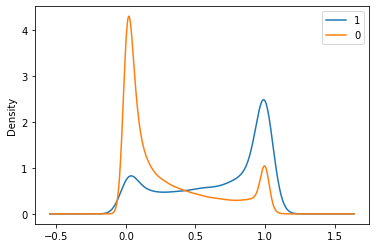

In [73]:
train[(train["SeriousDlqin2yrs"] == 1) & (train["RevolvingUtilizationOfUnsecuredLines"] < train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.99))]["RevolvingUtilizationOfUnsecuredLines"].plot.density(label = '1') 
train[(train["SeriousDlqin2yrs"] == 0) & (train["RevolvingUtilizationOfUnsecuredLines"] < train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.99))]["RevolvingUtilizationOfUnsecuredLines"].plot.density(label = '0')
plt.legend() 

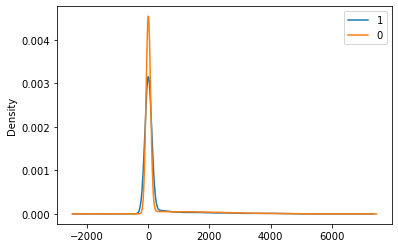

In [74]:
train[(train["SeriousDlqin2yrs"] == 1) & (train["DebtRatio"] < train["DebtRatio"].quantile(0.99))]["DebtRatio"].plot.density(label = '1') 
train[(train["SeriousDlqin2yrs"] == 0) & (train["DebtRatio"] < train["DebtRatio"].quantile(0.99))]["DebtRatio"].plot.density(label = '0')
plt.legend() 

There definitely appears to be some signal in variable 1, as the distributions diverge considerably. Not as much for variable 4. For variable 1, however, that top 1 percent of values, even top 0.5 percent of values, still seems to have considerable signal (remember from the initial descriptive statistics that the percentage of positives is roughly 0.065). 

In [75]:
train[train["RevolvingUtilizationOfUnsecuredLines"] > train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.99)]["SeriousDlqin2yrs"].mean()

0.3925233644859813

In [76]:
train[train["RevolvingUtilizationOfUnsecuredLines"] > train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.995)]["SeriousDlqin2yrs"].mean()

0.29906542056074764

But the signal seems to have largely disappeared by the time we are looking at values above the 99.9th percentile

In [77]:
train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.999)

1572.6200000001118

In [78]:
train[train["RevolvingUtilizationOfUnsecuredLines"] > train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.999)]["SeriousDlqin2yrs"].mean()

0.06

So let's remove values above this cutoff.

In [79]:
train = train[train["RevolvingUtilizationOfUnsecuredLines"] <= train["RevolvingUtilizationOfUnsecuredLines"].quantile(0.999)]

Similarly, for variable 3 (debt ratio), we can see that the signal in the top 1 percent is somewhat minimal to begin with, so we'll drop these values. The abridged dataset is roughly 148,000 observations strong.

In [80]:
train = train[train["DebtRatio"] <= train["DebtRatio"].quantile(0.99)]

In [81]:
train.shape

(148086, 11)

We still need to take care of those NA values. Let's see how many are left at this point.

In [82]:
train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           28162
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3801
dtype: int64

We'll try 3 approaches, resulting in 3 different datasets: 

1.   Simply drop the NA values ("train_short1")
2.   Impute missing values with the median of each column ("train_short2")
3.   Use sklearn's iterative imputer, which estimates the data values for each feature based on all other feature values in a round-robin fashion
("train_short3")

Of these 3 techniques, 1 and 2 seem somewhat naive. Method 3 is more tailed to the particulars of the data, so we'd expect the associated dataset to be the most reliable.



In [83]:
# update the trainX and trainy datasets
train.reset_index(drop = True, inplace = True)
trainX = train.iloc[:, 1:11]
trainy = train.iloc[:,0]

In [84]:
train_short1 = train.dropna() #drop all NA values
train_short2 = trainX.fillna(trainX.median()) # impute medians of columns in place of all NA values

In [85]:
imp_mean = IterativeImputer(random_state=0) # use iterative imputer to fill missing values
imp_mean.fit(trainX)
train_short3 = pd.DataFrame(imp_mean.transform(trainX))

We can see that the Iterative Imputer gave some observations negative vlaues for Monthly Income and Number of Dependents. Let's drop those. 

In [86]:
train_short3.describe()

,0,1,2,3,4,5,6,7,8,9
count,148086.000000,148086.000000,148086.000000,148086.000000,1.480860e+05,148086.000000,148086.000000,148086.000000,148086.000000,148086.000000
mean,0.716075,52.308199,0.244810,269.807261,5.739026e+03,8.429007,0.090940,1.001020,0.065030,0.751422
std,19.908916,14.791825,0.695967,780.905267,1.318023e+04,5.116680,0.486841,1.102863,0.330851,1.103804
min,0.000000,0.000000,0.000000,0.000000,-1.101800e+04,0.000000,0.000000,0.000000,0.000000,-0.409539
25%,0.029586,41.000000,0.000000,0.173869,2.863000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.151991,52.000000,0.000000,0.362803,4.789916e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.552951,63.000000,0.000000,0.819749,7.450000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1571.000000,109.000000,13.000000,4983.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


In [87]:
trainy3 = trainy[train_short3[9] >= 0]

In [88]:
train_short3 = train_short3[train_short3[9] >= 0]

Reset indices of each dataset (for neatness), and change names of each column to numbers (for consistency)

In [89]:
train_short1.reset_index(drop = True, inplace = True)
train_short2.reset_index(drop = True, inplace = True)
train_short3.reset_index(drop = True, inplace = True)

In [90]:
columnchange = {"RevolvingUtilizationOfUnsecuredLines": "0", "age": "1", "NumberOfTime30-59DaysPastDueNotWorse": "2", "DebtRatio": "3", "MonthlyIncome": "4", "NumberOfOpenCreditLinesAndLoans": "5", "NumberOfTimes90DaysLate": "6", "NumberRealEstateLoansOrLines": "7", "NumberOfTime60-89DaysPastDueNotWorse": "8", "NumberOfDependents": "9"}

In [91]:
train_short1.rename(columns = columnchange, inplace = True)
train_short2.rename(columns = columnchange, inplace = True)

C:\Users\_\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Standardize the data

In [92]:
trainX1 = train_short1.iloc[:, 1:11]
trainy1 = train_short1.iloc[:,0]
trainX1 = (trainX1 - trainX1.mean())/trainX1.std()

trainX2 = train_short2
trainy2 = trainy
trainX2 = (trainX2 - trainX2.mean())/trainX2.std()

trainX3 = train_short3
trainy3 = trainy3
trainX3 = (trainX3 - trainX3.mean())/trainX3.std()

In [93]:
trainX3.shape

(147869, 10)

**Initial Algorithms: kNN and SVC**

We'll first try to do a basic kNN classifier on the dataset. We'll cross validate (5 fold) over a range of k-values from 1 up to 10, and find AUC for datasets 1-3. 
  1. Simple drop NA (obs = 119,924)
  2. Median Imputation (obs = 148,086)
  3. Iteratively Imputed (obs = 147,869)

In [44]:
from sklearn.model_selection import cross_validate

In [ ]:
ktests = range(1,11)
kresults1 = {}
kresults2 = {}
kresults3 = {}

for k in ktests:
  knn = KNeighborsClassifier(n_neighbors = k)
  results1 = cross_validate(knn, trainX1, trainy1, scoring = 'roc_auc', cv = 5, n_jobs = -1) # dropNA
  results2 = cross_validate(knn, trainX2, trainy2, scoring = 'roc_auc', cv = 5, n_jobs = -1) # Median Imputation
  results3 = cross_validate(knn, trainX3, trainy3, scoring = 'roc_auc', cv = 5, n_jobs = -1) # Iteratively Imputed
  kresults1[k] = results1['test_score'].mean()
  kresults2[k] = results2['test_score'].mean()
  kresults3[k] = results3['test_score'].mean()

The results for each dataset are below:

In [ ]:
kresults1

In [ ]:
kresults2

In [ ]:
kresults3

In [ ]:
lists1 = sorted(kresults1.items()) # sorted by key, return a list of tuples
lists2 = sorted(kresults2.items()) # sorted by key, return a list of tuples
lists3 = sorted(kresults3.items()) # sorted by key, return a list of tuples

x1, y1 = zip(*lists1) # unpack a list of pairs into two tuples
x2, y2 = zip(*lists2) # unpack a list of pairs into two tuples
x3, y3 = zip(*lists3) # unpack a list of pairs into two tuples

plt.plot(x1, y1, label = '1')
plt.plot(x2, y2, label = '2')
plt.plot(x3, y3, label = '3')
plt.ylabel('AUC')
plt.xlabel('k')
plt.title('k versus AUC for kNN')
plt.legend()
plt.show()

We can see that at least in the 1 to 10 range, increasing k always improves the AUC. The dropNA dataset performs slightly worse throughout than the other two datasets, which perform roughly equally for all values of k. Now we'll find the ROC for 10NN (which seems to perform best of the options) on a sample split of each dataset. 

In [ ]:
trainX11, trainX12, trainy11, trainy12 = train_test_split(trainX1, trainy1, test_size=0.2)
trainX21, trainX22, trainy21, trainy22 = train_test_split(trainX2, trainy2, test_size=0.2)
trainX31, trainX32, trainy31, trainy32 = train_test_split(trainX3, trainy3, test_size=0.2)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(trainX11,trainy11)
y_scores1 = knn.predict_proba(trainX12)
fpr1, tpr1, threshold1 = roc_curve(trainy12, y_scores1[:, 1])
roc_auc1 = auc(fpr1, tpr1)

In [ ]:
knn.fit(trainX21,trainy21)
y_scores2 = knn.predict_proba(trainX22)
fpr2, tpr2, threshold2 = roc_curve(trainy22, y_scores2[:, 1])
roc_auc2 = auc(fpr2, tpr2)

In [ ]:
knn.fit(trainX31,trainy31)
y_scores3 = knn.predict_proba(trainX32)
fpr3, tpr3, threshold3 = roc_curve(trainy32, y_scores3[:, 1])
roc_auc3 = auc(fpr3, tpr3)

The results, graphed below. 

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of 10NN (Dataset 1)')
plt.show()

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of 10NN (Dataset 2)')
plt.show()

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr3, tpr3, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of 10NN (Dataset 3)')
plt.show()

10NN doesn't perform too badly on the dataset. The AUC for dataset 1 is in the vicinity of 0.75, while the AUC for datasets 2 and 3 is in the vicinity of 0.76. Can SVC do better? Let's see! We'll use linear SVC, an sklearn routine that is essentially SVC, but with a linear kernel, and implemented in a way which scales better to larger datasets (like the ones that we have here).



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
svc = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))

Run 5 fold cross validation of linear SVC on each of our 3 datasets.

In [ ]:
svmresults1 = cross_validate(svc,trainX1, trainy1, scoring = 'roc_auc', cv = 5, n_jobs = -1)
svmresults2 = cross_validate(svc,trainX2, trainy2, scoring = 'roc_auc', cv = 5, n_jobs = -1)
svmresults3 = cross_validate(svc,trainX3, trainy3, scoring = 'roc_auc', cv = 5, n_jobs = -1)

In [ ]:
svmresults1['test_score'].mean()

In [ ]:
svmresults2['test_score'].mean()

In [ ]:
svmresults3['test_score'].mean()

Once again, dataset 3 comes on top, with dataset 2 close behind, and dataset 1 slightly more behind. Let's graph those ROC's on the same splits we used for 10NN to get a better visual of what is going on.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
clf2 = CalibratedClassifierCV(svc)

In [ ]:
clf2.fit(trainX11, trainy11)
y_scores4 = clf2.predict_proba(trainX12)

In [ ]:
clf2.fit(trainX21, trainy21)
y_scores5 = clf2.predict_proba(trainX22)

In [ ]:
clf2.fit(trainX31, trainy31)
y_scores6 = clf2.predict_proba(trainX32)

In [ ]:
fpr4, tpr4, threshold4 = roc_curve(trainy12, y_scores4[:, 1])
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, threshold5 = roc_curve(trainy22, y_scores5[:, 1])
roc_auc5 = auc(fpr5, tpr5)

fpr6, tpr6, threshold6 = roc_curve(trainy32, y_scores6[:, 1])
roc_auc6 = auc(fpr6, tpr6)

The ROC curves for linear SVC on each dataset split are graphed below:

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr4, tpr4, 'b', label = 'AUC = %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Linear SVC (Dataset 1)')
plt.show()

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr5, tpr5, 'b', label = 'AUC = %0.2f' % roc_auc5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Linear SVC (Dataset 2)')
plt.show()

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr6, tpr6, 'b', label = 'AUC = %0.2f' % roc_auc6)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Linear SVC (Dataset 3)')
plt.show()

Overall, linear SVC performs slighly better on each of the datasets than 10NN does. It is the front-runner thus far. Next, we'll try Random Forests (see the next notebook for that).

**Runs on the Test Data**

Let's see how the two algorithms perform on Kaggle's test dataset. We first create two imputation versions of the test dataset (one using the iterative imputer, one using median fill), as there are some NA values in it.



In [96]:
testX = testX.iloc[:, 1:]

In [97]:
testXf1 = pd.DataFrame(imp_mean.transform(testX))
testXf2 = testX.fillna(testX.median())

Standardize both test datasets:

In [98]:
testXf1 = (testXf1 - testXf1.mean())/testXf1.std()
testXf2 = (testXf2 - testXf2.mean())/testXf2.std()

Fit the linear SVC learner to the third test dataset (iteratively imputed):

In [ ]:
clf2.fit(trainX3, trainy3)

Fit the results to the corresponding test dataset

In [ ]:
y_scorest1 = pd.DataFrame(clf2.predict_proba(testXf1))

Submitting to Kaggle, we get an AUC of 0.77648. Slightly worse than what our initial results were saying, but not too far off, and not too bad. How about 10NN?

In [94]:
knn.fit(trainX3,trainy3)

KNeighborsClassifier(n_neighbors=6)

In [99]:
y_scorest2 = pd.DataFrame(knn.predict_proba(testXf1))

Kaggle gives us an AUC of 0.585 for 10NN, which is quite a bit less than what our initial results had given. However, this might be explained by outliers -- we were able to remove many of these for the training set, but not for Kaggle's test set -- which kNN is susceptible to, especially for low values of k. We'll wrap up this notebook by finding Kaggle's results for median imputation. For linear SVC:

In [ ]:
clf2.fit(trainX2, trainy2)

In [ ]:
y_scorest3 = pd.DataFrame(clf2.predict_proba(testXf2))

The AUC Kaggle gives is 0.775. For 10NN:

In [ ]:
knn.fit(trainX2,trainy2)

In [ ]:
y_scorest4 = pd.DataFrame(knn.predict_proba(testXf2))

The AUC is 0.587. 

In [100]:
y_scorest2

,0,1
0,1.000000,0.000000
1,1.000000,0.000000
2,0.833333,0.166667
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
101498,1.000000,0.000000
101499,0.500000,0.500000
101500,1.000000,0.000000
101501,1.000000,0.000000
